In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from tqdm.notebook import tqdm
from itertools import product
from datetime import datetime
import json
from statannotations.Annotator import Annotator
from matplotlib.ticker import ScalarFormatter, NullFormatter

import matplotlib.colors as mcolors
from tqdm.notebook import tqdm
from scipy import stats
import gym

import matplotlib.colors as mcolors
import matplotlib as mpl

from joblib import Parallel, delayed
import multiprocessing

# create a color map using a list of hex values for the IBM colorblind safe palette
hex_list = ['#648fff','#785ef0','#dc267f','#fe6100','#ffb000']
cmap = mpl.colors.LinearSegmentedColormap.from_list('ibm_cbs', hex_list)

def rgba_to_hex(rgba):
    return mcolors.rgb2hex(rgba)

def change_lightness(color, amount=0.5):
    """ amount can be between -1 and 1 """
    import colorsys
    try:
        c = mcolors.to_rgb(color)
        c = colorsys.rgb_to_hls(*c)
        return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    except ValueError:
        return color

def pvalue_to_stars(pvalue):
    if pvalue < 0.0001:
        return '****'
    elif pvalue < 0.001:
        return '***'
    elif pvalue < 0.01:
        return '**'
    elif pvalue < 0.05:
        return '*'
    else:
        return 'ns'

def pairedCohensD(x,y):
    """ Calculate the paired cohens d for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    return (np.mean(x-y) / np.std(x-y,ddof=1))

def cliffsDelta(x,y):
    """ Calculate the cliffs delta for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    prod = np.array(list(product(x,y)))
    diffs = np.int32(prod[:,0]<prod[:,1]) - np.int32(prod[:,0]>prod[:,1])
    return np.mean(diffs)

def pairedRankBiserialCorrelation(x,y):
    """ Calculate the paired rank biserial correlation for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    # calculate the signed rank
    signed_rank = np.sign(x-y)*stats.rankdata(np.abs(x-y))
    # get sum of positive and negative ranks
    pos_rank = np.sum(signed_rank[signed_rank>0])
    neg_rank = -np.sum(signed_rank[signed_rank<0])
    # calculate the proportion of positive and negative ranks
    pos_prop = pos_rank/(pos_rank+neg_rank)
    neg_prop = neg_rank/(pos_rank+neg_rank)
    # calculate the difference in proportion
    return pos_prop-neg_prop

def delta_to_effect(delta):
    """ Convert a cliffs delta to effect size """
    delta = np.abs(delta)
    if delta < 0.147:
        return 'neg'
    elif delta < 0.33:
        return '^'
    elif delta < 0.474:
        return '^^'
    elif delta > 0.474:
        return '^^^'
    else:
        return ''

def d_to_effect(d):
    """ Convert a Cohen's d to effect size """
    d = np.abs(d)
    if d < 0.2:
        return 'neg'
    elif d < 0.5:
        return '^'
    elif d < 0.8:
        return '^^'
    elif d > 0.8:
        return '^^^'
    else:
        return ''

def r_to_effect(r):
    """ Convert a rank biserial correlation to effect size according to Funder (2019)"""
    r = np.abs(r)
    if r < 0.1:
        return 'neg'
    elif r < 0.3:
        return '^'
    elif r < 0.4:
        return '^^'
    elif r > 0.4:
        return '^^^'
    else:
        return ''

In [3]:
# Define File Exceptions
file_exceptions = []

# Define Non-functional Arenas (arenas that had leaks or were otherwise unusable)
arena_exceptions = [4,5,6,7,8,9,10,11,12,13,14,15]

data_directory = '../../16FlYMaze/HALvMHO_white_noise_4y/data/'

files = list(filter(lambda v: np.all([i not in v for i in file_exceptions]) and os.path.isdir(data_directory+v),os.listdir(data_directory)))
arenas = list(filter(lambda v: np.all([i != v for i in arena_exceptions]),range(16)))

In [4]:
all_data_unfiltered = []

for i,folder in tqdm(product(arenas,files),total=len(arenas)*len(files)):
    try:
        with open(data_directory+f"{folder}/processed_data/fly_{i}.ydata", "r") as f:
            data = json.load(f)
            for d in data.keys():
                data[d] = np.array(data[d])
        with open(data_directory+f"{folder}/fly_{i}.yexperiment", "r") as f:
            experiment = json.load(f)
            data["fly_experiment"] = experiment["fly_experiment"] + "_4_13"
            data["arena"] = i
            data["folder"] = folder
        with open(data_directory+f"{folder}/config.yarena", "r") as f:
            config = json.load(f)
            data["odor_1"] = config["odor_1"]
            data["odor_2"] = config["odor_2"]
        data["starvation"] = '4-13 hrs'
        all_data_unfiltered.append(data)
    except Exception as e:
        print(f"Failed to load data for fly {i} in folder {folder}. Error: {e}")

  0%|          | 0/184 [00:00<?, ?it/s]

Failed to load data for fly 3 in folder exp212121_2022-09-16_19-20. Error: [Errno 2] No such file or directory: '../../16FlYMaze/HALvMHO_white_noise_4y/data/exp212121_2022-09-16_19-20/processed_data/fly_3.ydata'


In [5]:
# make a copy of the data
all_data = all_data_unfiltered.copy()
# filter data to only include flies that have completed at least 160 trials
all_data = list(filter(lambda v: v["trial_count"] >= 160,all_data))
all_data[0].keys()

# print all experiments
exps, invs, counts = np.unique([d["fly_experiment"] for d in all_data],return_counts=True,return_inverse=True)
for i in range(len(exps)):
    print(f"{exps[i]}: {counts[i]} flies")
    
exp_to_idx = {exps[i]:i for i in range(len(exps))}
idx_to_exp = {i:exps[i] for i in range(len(exps))}

exp_names = ["Fly {} Exp {}{} ".format(i+1, int(d['fly_experiment'].split("_")[0].split("exp")[1].split(".")[0])+1," (R)" if "reciprocal" in d['fly_experiment'] else "") for i,d in enumerate(all_data)]

exp0.csv_4_13: 3 flies
exp0_reciprocal.csv_4_13: 3 flies
exp1.csv_4_13: 3 flies
exp10.csv_4_13: 3 flies
exp10_reciprocal.csv_4_13: 3 flies
exp11.csv_4_13: 3 flies
exp11_reciprocal.csv_4_13: 3 flies
exp12.csv_4_13: 3 flies
exp12_reciprocal.csv_4_13: 3 flies
exp13.csv_4_13: 3 flies
exp13_reciprocal.csv_4_13: 3 flies
exp14.csv_4_13: 3 flies
exp14_reciprocal.csv_4_13: 3 flies
exp15.csv_4_13: 3 flies
exp15_reciprocal.csv_4_13: 3 flies
exp16.csv_4_13: 3 flies
exp16_reciprocal.csv_4_13: 3 flies
exp17.csv_4_13: 3 flies
exp17_reciprocal.csv_4_13: 3 flies
exp18.csv_4_13: 3 flies
exp18_reciprocal.csv_4_13: 3 flies
exp19.csv_4_13: 3 flies
exp19_reciprocal.csv_4_13: 3 flies
exp1_reciprocal.csv_4_13: 3 flies
exp2.csv_4_13: 3 flies
exp20.csv_4_13: 3 flies
exp20_reciprocal.csv_4_13: 3 flies
exp21.csv_4_13: 3 flies
exp21_reciprocal.csv_4_13: 3 flies
exp2_reciprocal.csv_4_13: 3 flies
exp3.csv_4_13: 3 flies
exp3_reciprocal.csv_4_13: 3 flies
exp4.csv_4_13: 3 flies
exp4_reciprocal.csv_4_13: 3 flies
exp5.cs

In [6]:
np.random.seed(8151999+7251998)
n_sample = 3
sample_idx = np.random.choice(len(all_data),n_sample,replace=False)


In [ ]:
## PLOTTING ##

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

# plot all flies for each experiment
df_full = []
overwrite = False

for n,(exp_name,data) in tqdm(enumerate(zip(exp_names,all_data))):
    
    reward = data["reward_delivered"]
    choice = data["chosen_odor"]-1

    odor_1_rewarded = np.where(np.logical_and(reward == 1, choice == 0))[0]
    odor_2_rewarded = np.where(np.logical_and(reward == 1, choice == 1))[0]
    odor_1_unrewarded = np.where(np.logical_and(reward == 0, choice == 0))[0]
    odor_2_unrewarded = np.where(np.logical_and(reward == 0, choice == 1))[0]

    baiting_probs = np.array([np.float32(t['reward_probability']) for t in data['experiment_states']])

    window_size = 10

    # plot the data
    if n in sample_idx:
        sns.set(style="white",font_scale=2.5)
        fig, ax = plt.subplots(1,1, figsize=(7,3))

    choice_ratio = np.convolve(choice == 0, np.ones(window_size), mode='full')[:-window_size]/(np.convolve(choice == 1, np.ones(window_size), mode='full')[:-window_size]+np.convolve(choice == 0, np.ones(window_size), mode='full')[:-window_size])
    reward_ratio = np.convolve(np.logical_and(reward == 1,choice == 0), np.ones(window_size), mode='full')[:-window_size]/(np.convolve(np.logical_and(reward == 1,choice == 1), np.ones(window_size), mode='full')[:-window_size]+np.convolve(np.logical_and(reward == 1,choice == 0), np.ones(window_size), mode='full')[:-window_size])

    if n in sample_idx:
        ax.plot(2*choice_ratio-1, color=cmap(0.25))
        ax.plot(2*reward_ratio-1, color=cmap(0.75))

    limit = 1.2*np.max([np.max(2*np.abs(choice_ratio[~np.isnan(choice_ratio)]-0.5)), np.max(2*np.abs(reward_ratio[~np.isnan(reward_ratio)]-0.5))])

    if n in sample_idx:
        ax.plot(odor_1_rewarded, limit*np.ones(len(odor_1_rewarded)), 'o', color=cmap(0.0), markersize=7)
        ax.plot(odor_2_rewarded, -limit*np.ones(len(odor_2_rewarded)), 'o', color=cmap(1.0), markersize=7)
        ax.plot(odor_1_unrewarded, limit*np.ones(len(odor_1_unrewarded)), 'o', color=cmap(0.0), markerfacecolor='none', markersize=7)
        ax.plot(odor_2_unrewarded, -limit*np.ones(len(odor_2_unrewarded)), 'o', color=cmap(1.0), markerfacecolor='none', markersize=7)

        plt.xticks([0,80,160])
        plt.yticks([-limit,-0.6,0,0.6,limit],['MHO','80:20','50:50','20:80','HAL'])

        plt.xlabel('Trials',)
        plt.text(-0.25, 0.5, 'Choice Ratio', rotation=90, transform=ax.transAxes, va='center', ha='center', color=cmap(0.25))
        plt.text(-0.35, 0.5, 'Reward Ratio', rotation=90, transform=ax.transAxes, va='center', ha='center', color=cmap(0.75))

        ax.tick_params(axis='both', which='both', length=0)
        plt.box(False)
        plt.title(exp_name)

        # add inset
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        axins = inset_axes(ax,width="20%",height="50%", bbox_to_anchor=(0.05, 0.05, 1.4, 0.5), bbox_transform=ax.transAxes, borderpad=0)
        axins.plot(baiting_probs[:,1],color=cmap(0.0))
        axins.plot(baiting_probs[:,2],color=cmap(1.0))
        axins.set_xticks([0,80,160])
        axins.set_xticklabels([0,80,160])
        axins.set_yticks([0,1])
        axins.set_yticklabels([0,1])
        axins.tick_params(axis='both', which='both', length=0)
        axins.set_xlabel('Trials')
        axins.set_ylabel('Bait Prob.')
        # turn off the frame
        for spine in axins.spines.values():
            spine.set_visible(False)
        # remove background
        axins.set_facecolor('none')
        # save the figure
        plt.savefig('figures/'+exp_name+'.pdf',bbox_inches='tight')
        plt.show()

    if not os.path.exists('data/blockwise_CvR.csv') or overwrite:
        # matching data
        probs = np.array([np.float32(t['reward_probability']) for t in data['experiment_states']])[:,1:].T
        # add 2 to the end of the baiting probabilities to make sure the last trial is included
        probs = np.concatenate([probs, np.ones((probs.shape[0],1))*2], axis=1)
        # determine block boundaries
        block_boundaries = np.where(np.logical_and(np.diff(probs[0,:]) != 0, np.diff(probs[1,:]) != 0))[0]
        # add a zero to the beginning of the block boundaries
        block_boundaries = np.concatenate([[0], block_boundaries])
        #  create matching dataframe
        df = pd.DataFrame(columns=['block length','choice ratio','reward ratio'])
        # iterate over blocks
        for i in range(len(block_boundaries)-1):
            # get the indices of the block
            block_indices = np.arange(block_boundaries[i], block_boundaries[i+1])
            # get the choices and choice ratio
            choices = choice[block_indices]
            choice_ratio = np.sum(choices == 0)/len(choices)
            # get the rewards and reward ratio
            rewards = reward[block_indices]
            reward_ratio = np.sum(np.logical_and(rewards == 1, choices == 0))/(np.sum(np.logical_and(rewards == 1, choices ==0))+np.sum(np.logical_and(rewards == 1, choices ==1)))
            # reward_ratio = np.nan_to_num(reward_ratio, nan=0.)
            # add to dataframe
            df.loc[i] = [len(block_indices), choice_ratio, reward_ratio]
        df_full.append(df)
    
if not os.path.exists('data/blockwise_CvR.csv') or overwrite:
    df_full = pd.concat(df_full)
    df_full.to_csv('data/blockwise_CvR.csv', index=False)

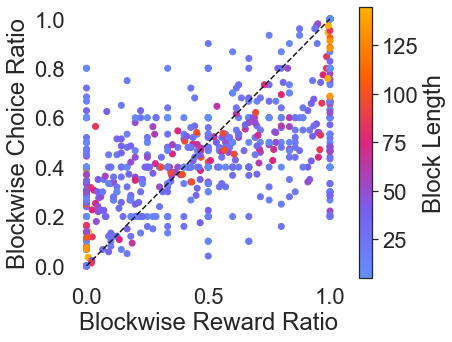

In [7]:
df_full = pd.read_csv('data/blockwise_CvR.csv')

sns.set(style="white",font_scale=2)
fig,ax = plt.subplots(1,1,figsize=(6,5))
scplot = ax.scatter(df_full['reward ratio'],df_full['choice ratio'],c=df_full['block length'],cmap=cmap)
ax.plot([0,1],[0,1],color='k',linestyle='--')
ax.set_xlabel('Blockwise Reward Ratio')
ax.set_ylabel('Blockwise Choice Ratio')
plt.box(False)
cbar = plt.colorbar(scplot)
cbar.set_label('Block Length')
plt.savefig('figures/blockwise_choice_reward_ratio.pdf',bbox_inches='tight')
plt.show()


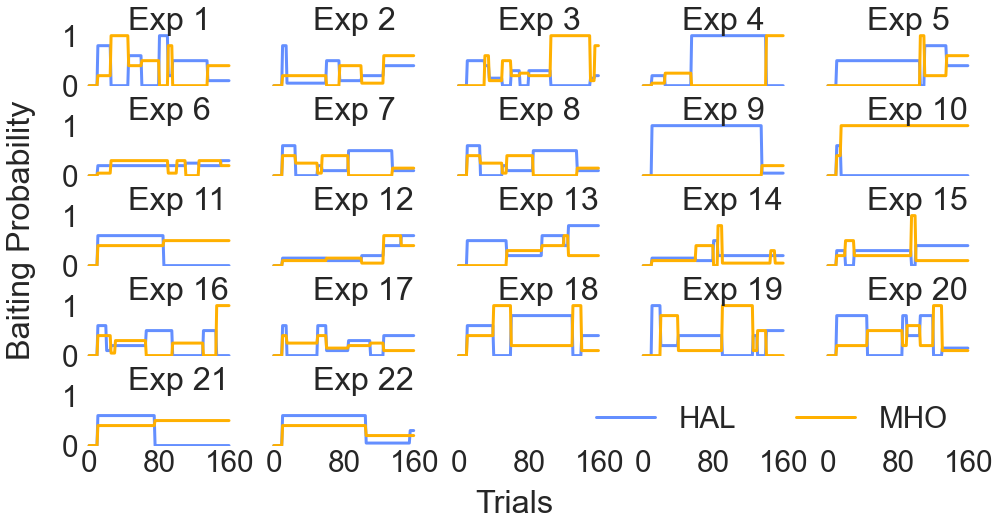

In [8]:
sns.set(style="white",font_scale=2.7)
fig,ax = plt.subplots(5,5,figsize=(16,8),sharex=True,sharey=True,gridspec_kw={'wspace':0.2,'hspace':0.2})
i = 0
experiments,counts = np.unique([data['fly_experiment'] for data in all_data], return_counts=True)
# sort experiments
experiments = experiments[np.argsort([int(exp.split('.')[0].split('exp')[1].split('_')[0]) for exp in experiments])]
for exp in [ex for ex in experiments if 'reciprocal' not in ex]:
    data = [d for d in all_data if d['fly_experiment'] == exp][0]
    baiting_probs = np.array([np.float32(t['reward_probability']) for t in data['experiment_states']])
    if i == 0:
        ax.flat[i].plot(baiting_probs[:,1],color=cmap(0.0),label='HAL',linewidth=3)
        ax.flat[i].plot(baiting_probs[:,2],color=cmap(1.0),label='MHO',linewidth=3)
    else:
        ax.flat[i].plot(baiting_probs[:,1],color=cmap(0.0),linewidth=3)
        ax.flat[i].plot(baiting_probs[:,2],color=cmap(1.0),linewidth=3)
    ax.flat[i].set_xticks([0,80,160])
    ax.flat[i].set_xticklabels([0,80,160])
    ax.flat[i].set_yticks([0,1])
    ax.flat[i].set_yticklabels([0,1])
    ax.flat[i].set_ylim([0,1.5])
    ax.flat[i].tick_params(axis='both', which='both', length=0)
    # add text
    ax.flat[i].text(0.3,0.75,'Exp '+str(int(exp.split('.')[0].split('xp')[1])+1),transform=ax.flat[i].transAxes)
    for spine in ax.flat[i].spines.values():
        spine.set_visible(False)
    i+=1
# remove axis for the remaining subplots
for j in range(i,25):
    for spine in ax.flat[j].spines.values():
        spine.set_visible(False)
    ax.flat[j].set_xticks([0,80,160])
    ax.flat[j].set_xticklabels([0,80,160])
    ax.flat[j].tick_params(axis='both', which='both', length=0)
    # turn off the white background
    ax.flat[j].set_facecolor('none')
# add common x and y labels
fig.text(0.5, 0.01, 'Trials', ha='center')
fig.text(0.06, 0.5, 'Baiting Probability', va='center', rotation='vertical')
# add legend
fig.legend(loc='lower right',ncol=2,frameon=False,bbox_to_anchor=(0.9,0.10))
plt.savefig('figures/baiting_probabilities.pdf',bbox_inches='tight')
plt.show()

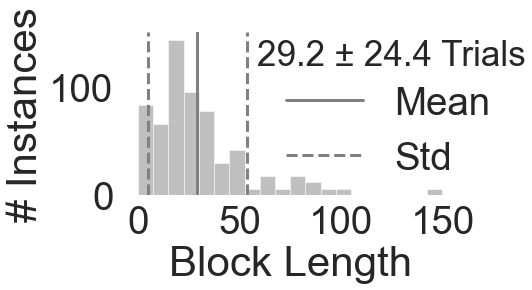

In [9]:
sns.set(style="white",font_scale=3.5)
fig,ax = plt.subplots(1,1,figsize=(6,3))
df_full[df_full['block length'] % 5 == 0]['block length'].hist(bins=np.linspace(0,150,21),ax=ax,color='gray',alpha=0.5)
# plot mean and std
ax.axvline(df_full[df_full['block length'] % 5 == 0]['block length'].mean(),color='grey',linestyle='-', linewidth=3, label='Mean')
ax.axvline(np.quantile(df_full[df_full['block length'] % 5 == 0]['block length'],0.025),color='grey',linestyle='--',linewidth=3, label='Std')
ax.axvline(np.quantile(df_full[df_full['block length'] % 5 == 0]['block length'],0.975),color='grey',linestyle='--',linewidth=3)
# add text
ax.text(0.4,0.8,'{} ± {}'.format(np.round(df_full[df_full['block length'] % 5 == 0]['block length'].mean(),1),np.round(df_full[df_full['block length'] % 5 == 0]['block length'].std(),
                                1)) + ' Trials',transform=ax.transAxes, fontsize=35)
ax.set_xlabel('Block Length')
ax.set_ylabel('# Instances')
ax.set_xticks([0,50,100,150])
ax.legend(loc='lower right',frameon=False, bbox_to_anchor=(1.2,-0.1))
plt.box(False)

plt.grid(False)
plt.savefig('figures/block_length_distribution.pdf',bbox_inches='tight')
plt.show()

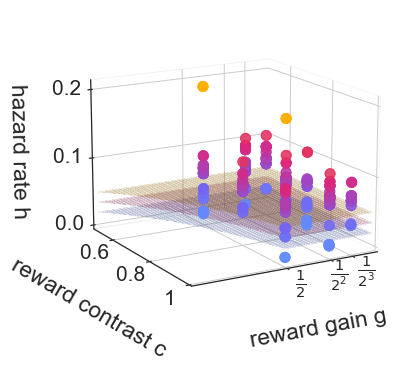

In [10]:
full_task_space = []
for data in all_data:
    baiting_probs = np.array([np.float32(t['reward_probability']) for t in data['experiment_states']])
    baiting_probs = np.concatenate([baiting_probs[10:,1:],5*np.ones(2).reshape(1,2)],axis=0)
    # find all changes in baiting probabilities
    baiting_prob_changes = np.where(np.diff(baiting_probs[:,0]) != 0)[0]+1
    block_sizes = np.diff(np.concatenate([[0],baiting_prob_changes]))[:-1]
    h_cap = round(np.mean(1/block_sizes),3)
    # values at change points
    baiting_prob_values = baiting_probs[np.concatenate([[0],baiting_prob_changes])[:-1],:]
    # points in task space
    task_space = []
    for i in baiting_prob_values:
        contrast = round(np.max(i)/(i[0]+i[1]),3)
        gain = round((i[0]+i[1])/2,3)
        task_space.append([contrast,gain,h_cap])
    full_task_space.append(task_space)
full_task_space = np.concatenate(full_task_space,axis=0)

# generate points for a plane in the reward contrast and gain space
xx, yy = np.meshgrid(np.linspace(0.5, 1, 1000), np.linspace(0, 1, 1000))
z = np.float32(np.logical_and(np.logical_and(yy * 2 * xx <= 1, yy * 2 * xx >= 0), np.logical_and(yy * 2 * (1 - xx) <= 1, yy * 2 * (1 - xx) >= 0)))
z[z==0] = np.nan

# plot all combinations
sns.set(style="white",font_scale=1.9)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# add a plane at each hazard rate
for hazard_rate in [0.05,0.035,0.02]:
    ax.plot_surface(yy, xx, z * hazard_rate, color=cmap((hazard_rate-0.02)/0.03), alpha=0.1, linewidth=0, antialiased=False)

ax.scatter(full_task_space[:, 1], full_task_space[:, 0], full_task_space[:, 2], c=cmap((full_task_space[:,2]-np.min(full_task_space[:,2]))/(np.max(full_task_space[:,2])-np.min(full_task_space[:,2]))), s=100, alpha=0.5)
ax.set_xlabel("reward gain g")
ax.set_ylabel("reward contrast c")
ax.set_zlabel("hazard rate h")
ax.set_xlim(0, 1)
ax.set_ylim(0.5, 1)
ax.set_yticks([0.6, 0.8, 1])
ax.set_yticklabels(["0.6  ", "0.8  ", "1  "], ha="center", va="center")
ax.set_xticks([0.125, 0.25, 0.5])
ax.set_xticklabels([r"  $\frac{1}{2^3}$", r"$\frac{1}{2^2}$" , r"  $\frac{1}{2}$"], ha="center", va="center",)
ax.set_zticks([0.0,0.1,0.2])
ax.set_zticklabels(["0.0  ","0.1  ","0.2  "], ha="center", va="center")
ax.xaxis.labelpad = 25
ax.yaxis.labelpad = 25
ax.zaxis.labelpad = 25
# remove background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# change viewing angle
ax.view_init(15, 60)
plt.savefig('figures/task_space.pdf',bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


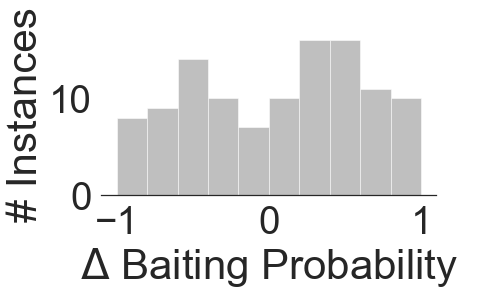

In [11]:
experiments,counts = np.unique([data['fly_experiment'] for data in all_data], return_counts=True)
experiments = experiments[np.argsort([int(exp.split('.')[0].split('xp')[1].split('_')[0]) for exp in experiments])]
deltas = []
for exp in [ex for ex in experiments if 'reciprocal' not in ex]:
    data = [d for d in all_data if d['fly_experiment'] == exp][0]
    baiting_probs = np.array([np.float32(t['reward_probability']) for t in data['experiment_states']])
    delta = np.diff(baiting_probs[:,1])
    delta = delta[delta != 0]
    deltas.append(delta)
deltas = np.concatenate(deltas)

sns.set(style="white",font_scale=3.5)
fig,ax = plt.subplots(1,1,figsize=(6,3))
ax.hist(deltas,bins=np.linspace(-1,1,11),color='gray',alpha=0.5)
ax.set_xlabel(r'$\Delta$ Baiting Probability')
ax.set_ylabel('# Instances')
# ax.set_xticks([0,50,100,150])
ax.legend(loc='lower right',frameon=False, bbox_to_anchor=(1.2,0.00))
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['bottom'].set_visible(True)
plt.grid(False)
plt.savefig('figures/baiting_prob_change_distribution.pdf',bbox_inches='tight')
plt.show()
    